# Test lagged covariance interpolation

In [1]:
# import sys
# sys.path.append('../CODE')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal

from oceanoi import cov, oi, variogram

In [4]:
%matplotlib inline

((30, 36), (36,), (30,))

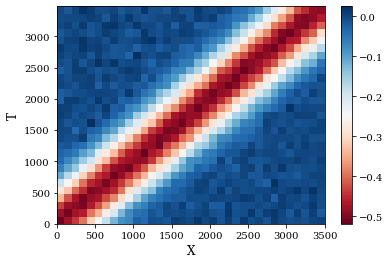

In [39]:
# Create a dataset for a propagating (soliton-like) signal

# parameters
a0=0.5
lx = 600.
c = 1.
x0 = 0.
tmax = 3600.

dx = 100
dt = 120.
x = np.arange(0, tmax*c, dx)
t = np.arange(0, tmax, dt)

X,T = np.meshgrid(x,t)

u = -a0*np.exp( -( (X-c*T-x0)/lx)**2) + 0.01*np.random.normal(size=X.shape)



plt.figure()
plt.pcolormesh(X,T,u,cmap='RdBu')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('T')
u.shape, x.shape, t.shape


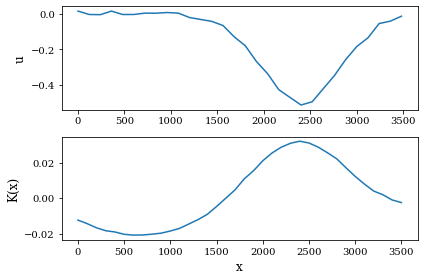

In [40]:
# Let's just look at the covariance of a point in space
Kuu =  np.cov(u.T)
x.shape, Kuu.shape

pt = 24
plt.figure()
plt.subplot(211)
plt.plot(t,u[:,pt])
plt.ylabel('u')

plt.subplot(212)
plt.plot(x,Kuu[pt,:])
plt.ylabel('K(x)')
plt.xlabel('x')
plt.tight_layout()

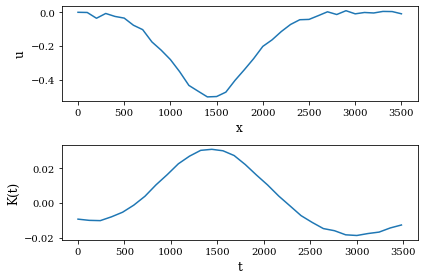

In [41]:
# Do the covariance with time dimension
Ktt =  np.cov(u)
x.shape, Ktt.shape

pt = 12
plt.figure()
plt.subplot(211)
plt.plot(x,u[pt,:])
plt.ylabel('u')
plt.xlabel('x')

plt.subplot(212)
plt.plot(t,Ktt[pt,:])
plt.ylabel('K(t)')
plt.xlabel('t')
plt.tight_layout()


# Variogram calculation method

1-D variogram:

$$
\gamma(h) = \frac{1}{2N(h)} \sum_i^{N(h)} [z(x_i) - z(x_i + h)]^2
$$

Steps:
 1. Compute the distance of vector $X$ with itself i.e. `h = X - X.T`
 2. Find the lags using `np.digitize`

For each lag value:
 3. Compute the number of points $N(h)$
 4. Compute the variogram value

2-D variogram:

$$
\gamma(h,l) = \frac{1}{2N(h,l)} \sum_i^{N(h,l)} [z(x_i,y_i) - z(x_i + h, y_i+l)]^2
$$

Relationship between variogram and covariance:
$$
C(h) = sill - \gamma(h)
$$

CPU times: user 67.5 ms, sys: 46.8 ms, total: 114 ms
Wall time: 56.6 ms


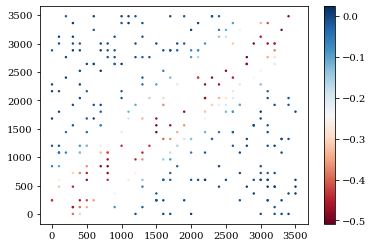

In [42]:
%%time
# Take a random sample of the data for a 2D 
nt,nx = u.shape
nsamples = 300
rr = np.random.randint(nt,size=nsamples)
cc = np.random.randint(nx,size=nsamples)

xx = X[rr,cc]
yy = T[rr,cc]
Z = u[rr,cc]

plt.figure()
plt.scatter(xx,yy,2,c=Z, cmap='RdBu')
plt.colorbar()

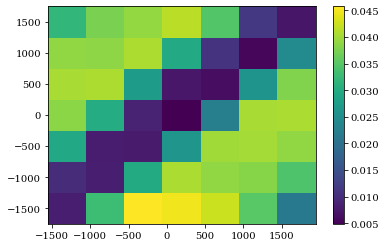

In [43]:
dx=500
dy=500
xbins = np.arange(-1800,1800+dx,dx)
ybins = np.arange(-2000,2000+dy,dy)

hx, hy, v, N = variogram.calc_variogram_2d(xx,yy,Z,xbins,ybins)
plt.figure()
plt.pcolormesh(hx, hy, v)
plt.colorbar()

In [1]:
# Fit a covariance model to the data
sill = v.max()
Cxt = sill - v
#Cxt/=sill
Hx, Hy = np.meshgrid(hx,hy)

scale=1e-3

covfunc = cov.matern_cov_2d
covparams = (1., 1000*scale,1000*scale, 10.)
soln=cov.optimize_covariance_model(cov.matern_cov_2d, Hx*scale, Hy*scale, Cxt, 0,0, covparams)
print(soln)
Cfit = cov.matern_cov_2d( Hx*scale, Hy*scale, 0,0, soln['x'])

plt.figure()
plt.pcolormesh(Hx, Hy, Cfit)
plt.colorbar()


covparams = soln['x']
covparams[1] = covparams[1]*1000
covparams[2] = covparams[2]*1000
print(covparams)

NameError: name 'v' is not defined

In [45]:
%%time
# Optimal interpolation using scatter data
nt,nx = u.shape
nsamples = 700
rr = np.random.randint(nt,size=nsamples)
cc = np.random.randint(nx,size=nsamples)

xtest = X[rr,cc]
ytest = T[rr,cc]
ztest = u[rr,cc]



U_oi = np.zeros_like(X)
for ii in range(X.shape[0]):
    if ii%20==0:
        print(ii, X.shape[0])
        
    Xm = X[ii,:]
    Tm = T[ii,:]
    sd = 0.001
    OI = oi.OptimalInterp2D(xtest, ytest, Xm.ravel(), Tm.ravel(), sd, covfunc, covparams)
    U_oi[ii,:] = OI(ztest[:,None]).ravel()

# plt.figure()
# plt.scatter(xtest,ytest,2,c=ztest, cmap='RdBu')
# plt.colorbar()

0 30
20 30
CPU times: user 3.85 s, sys: 3.36 s, total: 7.21 s
Wall time: 2.09 s


((30, 36), (36,), (30,))

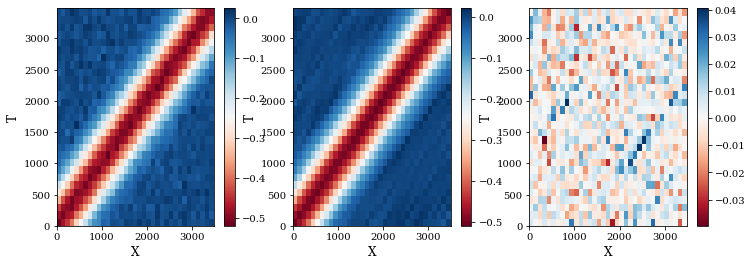

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X,T,u,cmap='RdBu')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('T')
plt.subplot(132)
plt.pcolormesh(X,T,U_oi,cmap='RdBu')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('T')

plt.subplot(133)
plt.pcolormesh(X,T,U_oi-u,cmap='RdBu')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('T')
u.shape, x.shape, t.shape


----
# Miscellaneous code below this point
----

In [41]:
def calc_variogram_1d(X, Z, xbins):
    """
    Calculate variogram parameters along 1-dimension
    """
    nx = X.shape
    xall = np.repeat(X[:,None],nx,axis=1)
    #xdist = xall - xtest
    xdist = xall - xall.T # Distance between all points in a vector with every other point
    #xdist = np.abs(xdist)

    h = 0.5*(bins[0:-1] + bins[1:])
    nbins = h.shape[0]
    v = np.zeros_like(h)
    N = np.zeros_like(h)
    # Load 
    for ii in range(nbins):
        idx = (xdist>=bins[ii]) & (xdist <=bins[ii+1])
        rc = np.argwhere(idx)
        v[ii] = np.sum( np.power(Z[rc[:,0]]-Z[rc[:,1]],2) )
        N[ii] = idx.sum()
    
    return h, v/(2*N), N
    
# Calculate the lag in x and t

# Include just one time step
X = x[:]
Z = u[100,:]

# Include multiple time steps
X = np.repeat(x[None,:],10,axis=0).ravel()
Z = u[100:110,:].ravel()
bins = np.arange(-10050,10150,100)

h,V = calc_variogram_1d(X, Z, bins)

plt.figure()
plt.plot(h, V)
#plt.plot(h,N)

ValueError: too many values to unpack (expected 2)

In [77]:
0.5/0.005

100.0

<IPython.core.display.Javascript object>


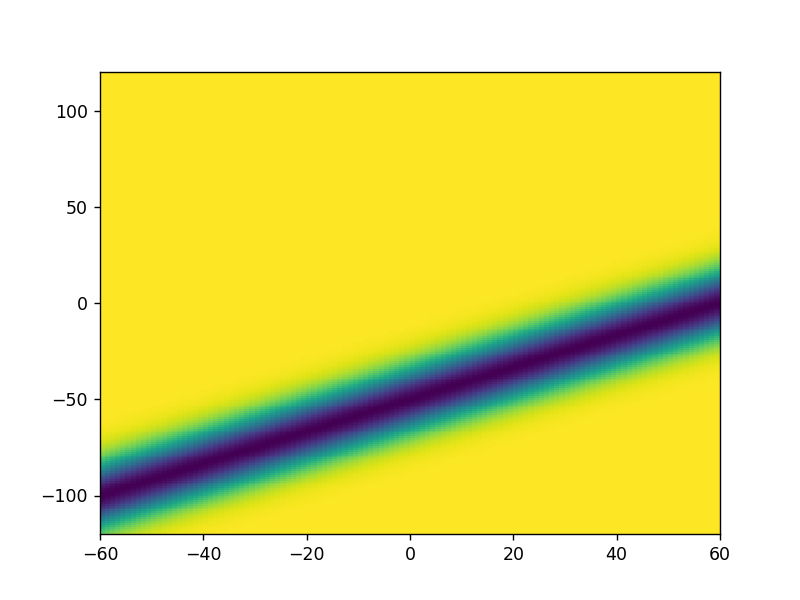

In [91]:
# Choose a point in space and calculate covariances for lags in space and time

xpt = 300
tpt = 300

tlags = 120
slags = 60


C_hu = np.zeros((2*tlags+1, 2*slags+1))

u1in = u[xpt-tlags:xpt+tlags, tpt-slags:tpt+slags]

ss = np.arange(-slags,slags+1)
tt = np.arange(-tlags,tlags+1)

C_hu = u[xpt,tpt] * u1in

plt.figure()
plt.pcolormesh(ss,tt, C_hu)



In [59]:
def calc_lag_cov_vector(u1,u2, maxlag, i1,i2, lagdirn='both'):
    """
    Calculate the lagged covariance between two vectors
    """

    mu1 =  np.mean(u1[i1:i2])
    sig1 = np.std(u1[i1:i2])
    
    u1in = u1[i1:i2,None] - mu1
    N = i2-i1
    
    if lagdirn =='both':
        lags = range(-maxlag,maxlag+1)
    elif lagdirn == 'forward':
        lags = range(-maxlag,1)
    elif lagdirn == 'backward':
        lags = range(0, maxlag+1)
    
    C = np.zeros((len(lags),))
    
    #mu2 = np.mean(u2[i1:i2])
    #sig2 = np.std(u2[i1:i2])
    
    ii = -1
    for k in lags:
        ii+=1
        mu2 = np.mean(u2[i1+k:i2+k])
        #sig2 = np.std(u2[i1+k:i2+k])

        u2in = u2[i1+k:i2+k,None] - mu2
        C[ii] = u1in.T.dot(u2in)/N #/(sig1*sig2)
        
    return C, np.array(lags)

def calc_lag_max(C,lags):
    idx = np.argwhere(C==C.max())[0,0]
    return C[idx], lags[idx]
    



<IPython.core.display.Javascript object>


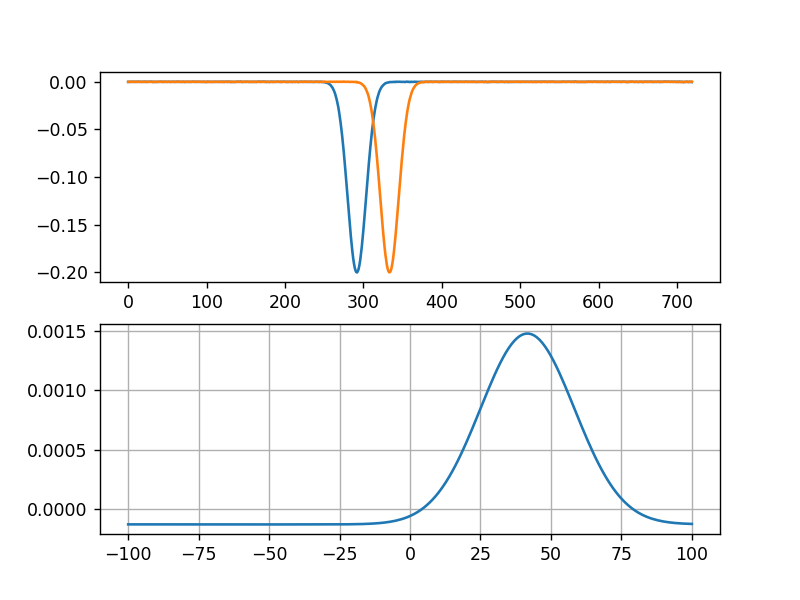

(0.0014800119150502288, 42)


In [62]:
u1 = u[:,350]
u2 = u[:,400]

# Start and end indices over which to compute the covariance
# i1 = 3500-1440
# i2 = i1+1440 # 2 days

maxlag = 100
i1 = maxlag+1
i2 = u1.shape[0]-maxlag

C, lags = calc_lag_cov_vector(u1,u2, maxlag, i1,i2, lagdirn='both')

plt.figure()
plt.subplot(211)
plt.plot(u1)
plt.plot(u2)

plt.subplot(212)
plt.plot(lags,C)
plt.grid(b=True)

print(calc_lag_max(C,lags) )

In [68]:
maxlag = 120
#Uin = upr
#Uin = vs-vpr
Uin = u
i1 = maxlag+1
i2 = u1.shape[0]-maxlag
# lagdirn = 'forward'
# k = maxlag+1

lagdirn='both'
k = 2*maxlag+1

i1 = maxlag+1
i2 = u1.shape[0]-maxlag

nx = Uin.shape[1]
lag_cov = np.zeros((nx,k))
lag_time = np.zeros((nx,k))
lag_cov_max = np.zeros((nx,))
lag_time_max = np.zeros((nx,))

for ii in range(nx):
    u1 = Uin[:,400]
    u2 = Uin[:,ii]
    lag_cov[ii,:], lag_time[ii,:] = calc_lag_cov_vector(u1,u2, maxlag, i1,i2, lagdirn=lagdirn)
    lag_cov_max[ii], lag_time_max[ii] = calc_lag_max(lag_cov[ii,:], lag_time[ii,:])
   

In [69]:
plt.figure()
plt.plot(x,lag_time_max)

<IPython.core.display.Javascript object>